# CCC Python Implementation Profiling

This notebook provides quantitative profiling evidence showing what percentage of CCC (Clustermatch Correlation Coefficient) runtime is attributable to ARI (Adjusted Rand Index) calculations.

**Goal**: Address reviewer feedback requesting profiling data to support the claim that ARI computation represents the main computational bottleneck in CCC.

## Setup

In [6]:
import sys
import os
import cProfile
import pstats
import io
from pstats import SortKey

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the libs directory to the path
sys.path.insert(0, os.path.abspath('../../libs'))

from ccc.coef.impl import ccc
from ccc.sklearn.metrics import adjusted_rand_index, get_pair_confusion_matrix, get_contingency_matrix

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete.")

Setup complete.


## Helper Functions

In [7]:
def generate_synthetic_data(n_features: int, n_samples: int, seed: int = 42) -> np.ndarray:
    """Generate synthetic numerical data for benchmarking.
    
    Args:
        n_features: Number of features (rows)
        n_samples: Number of samples (columns)
        seed: Random seed for reproducibility
    
    Returns:
        2D numpy array of shape (n_features, n_samples)
    """
    np.random.seed(seed)
    return np.random.rand(n_features, n_samples)


def profile_ccc(data: np.ndarray, n_jobs: int = 1) -> pstats.Stats:
    """Profile the CCC function and return stats.
    
    Args:
        data: Input data array
        n_jobs: Number of CPU cores to use
    
    Returns:
        pstats.Stats object with profiling results
    """
    profiler = cProfile.Profile()
    profiler.enable()
    
    result = ccc(data, n_jobs=n_jobs)
    
    profiler.disable()
    
    # Create stats object
    stats = pstats.Stats(profiler)
    return stats, result


# Function category definitions
FUNCTION_CATEGORIES = {
    # ARI Computation (the main bottleneck)
    'adjusted_rand_index': 'ARI',
    'get_pair_confusion_matrix': 'ARI',
    'get_contingency_matrix': 'ARI',
    
    # Partitioning
    'get_parts': 'Partitioning',
    'run_quantile_clustering': 'Partitioning',
    'get_feature_parts': 'Partitioning',
    'get_range_n_clusters': 'Partitioning',
    'get_perc_from_k': 'Partitioning',
    
    # Ranking
    'rank': 'Ranking',
    
    # Coordination/Orchestration
    'cdist_parts_basic': 'Coordination',
    'compute_ccc': 'Coordination',
    'compute_coef': 'Coordination',
    'ccc': 'Coordination',
    'get_chunks': 'Coordination',
    'get_coords_from_index': 'Coordination',
    'get_feature_type_and_encode': 'Coordination',
}

# Category colors for visualization
CATEGORY_COLORS = {
    'ARI': '#e74c3c',           # Red
    'Partitioning': '#3498db',   # Blue
    'Ranking': '#9b59b6',        # Purple
    'Coordination': '#2ecc71',   # Green
    'NumPy/Numba': '#f39c12',    # Orange
    'Other': '#95a5a6',          # Gray
}


def categorize_function(func_name: str, filename: str) -> str:
    """Categorize a function based on its name and source file.
    
    Args:
        func_name: Name of the function
        filename: Source file path
        
    Returns:
        Category string
    """
    # Check predefined categories first
    if func_name in FUNCTION_CATEGORIES:
        return FUNCTION_CATEGORIES[func_name]
    
    # Check if it's a NumPy/Numba internal function
    numpy_funcs = ['searchsorted', 'argsort', 'zeros', 'unique', 'full', 
                   'ravel', 'dot', 'sum', 'max', 'argmax', 'floor', 'sqrt',
                   'ceil', 'round', 'array', 'arange', 'empty', 'copy']
    if func_name in numpy_funcs or 'numpy' in filename.lower() or 'numba' in filename.lower():
        return 'NumPy/Numba'
    
    # Check if it's from CCC codebase
    if 'ccc' in filename.lower():
        return 'Other CCC'
    
    return 'Other'


def extract_all_function_times(stats: pstats.Stats, top_n: int = 20, 
                                min_pct: float = 0.1) -> tuple:
    """Extract comprehensive timing information for ALL functions.
    
    Args:
        stats: pstats.Stats object
        top_n: Number of top functions to return
        min_pct: Minimum percentage of total time to include
    
    Returns:
        Tuple of (DataFrame with all functions, total_time)
    """
    stats_dict = stats.stats
    
    # Find total time from ccc function
    total_time = 0
    for key, value in stats_dict.items():
        filename, line_num, func_name = key
        if func_name == 'ccc' and 'impl.py' in filename:
            total_time = value[3]  # cumtime
            break
    
    if total_time == 0:
        # Fallback: use the max cumtime
        total_time = max(v[3] for v in stats_dict.values())
    
    # Extract all function data
    func_data = []
    for key, value in stats_dict.items():
        filename, line_num, func_name = key
        ncalls, tottime, cumtime = value[0], value[2], value[3]
        
        # Calculate percentage
        pct = (tottime / total_time) * 100 if total_time > 0 else 0
        
        # Skip very small contributions
        if pct < min_pct:
            continue
        
        # Get category
        category = categorize_function(func_name, filename)
        
        # Get short filename
        short_file = filename.split('/')[-1] if '/' in filename else filename
        
        func_data.append({
            'Function': func_name,
            'File': short_file,
            'Category': category,
            'Calls': ncalls,
            'TotTime': tottime,
            'CumTime': cumtime,
            'TotTime%': pct,
            'CumTime%': (cumtime / total_time) * 100 if total_time > 0 else 0
        })
    
    # Create DataFrame and sort by TotTime
    df = pd.DataFrame(func_data)
    df = df.sort_values('TotTime', ascending=False).head(top_n)
    df = df.reset_index(drop=True)
    
    return df, total_time


def extract_function_times(stats: pstats.Stats) -> dict:
    """Extract timing information for key functions from profiling stats.
    
    Args:
        stats: pstats.Stats object
    
    Returns:
        Dictionary with function names and their cumulative times
    """
    # Get all stats
    stats_dict = stats.stats
    
    # Functions we're interested in
    ari_functions = [
        'adjusted_rand_index',
        'get_pair_confusion_matrix', 
        'get_contingency_matrix'
    ]
    
    partitioning_functions = [
        'get_parts',
        'run_quantile_clustering',
        'get_feature_parts'
    ]
    
    other_functions = [
        'cdist_parts_basic',
        'compute_ccc',
        'compute_coef',
        'ccc'
    ]
    
    results = {
        'ari': {},
        'partitioning': {},
        'other': {},
        'total_time': 0.0
    }
    
    for key, value in stats_dict.items():
        filename, line_num, func_name = key
        # value is (ncalls, tottime, cumtime, callers)
        ncalls, tottime, cumtime = value[0], value[2], value[3]
        
        if func_name in ari_functions:
            results['ari'][func_name] = {
                'ncalls': ncalls,
                'tottime': tottime,
                'cumtime': cumtime
            }
        elif func_name in partitioning_functions:
            results['partitioning'][func_name] = {
                'ncalls': ncalls,
                'tottime': tottime,
                'cumtime': cumtime
            }
        elif func_name in other_functions:
            results['other'][func_name] = {
                'ncalls': ncalls,
                'tottime': tottime,
                'cumtime': cumtime
            }
        
        # Track total time from the ccc function
        if func_name == 'ccc' and 'impl.py' in filename:
            results['total_time'] = cumtime
    
    return results


def calculate_percentages(results: dict) -> dict:
    """Calculate percentage of total time for each category.
    
    Args:
        results: Dictionary from extract_function_times
    
    Returns:
        Dictionary with percentages
    """
    total = results['total_time']
    if total == 0:
        return {'ari_pct': 0, 'partitioning_pct': 0, 'other_pct': 0}
    
    # Sum up tottime (exclusive time) for each category
    ari_time = sum(v['tottime'] for v in results['ari'].values())
    part_time = sum(v['tottime'] for v in results['partitioning'].values())
    
    return {
        'ari_time': ari_time,
        'ari_pct': (ari_time / total) * 100,
        'partitioning_time': part_time,
        'partitioning_pct': (part_time / total) * 100,
        'other_time': total - ari_time - part_time,
        'other_pct': ((total - ari_time - part_time) / total) * 100,
        'total_time': total
    }


def calculate_category_totals(func_df: pd.DataFrame, total_time: float) -> pd.DataFrame:
    """Calculate total time spent in each category.
    
    Args:
        func_df: DataFrame from extract_all_function_times
        total_time: Total CCC execution time
        
    Returns:
        DataFrame with category totals
    """
    category_totals = func_df.groupby('Category').agg({
        'TotTime': 'sum',
        'Calls': 'sum'
    }).reset_index()
    
    category_totals['Percentage'] = (category_totals['TotTime'] / total_time) * 100
    category_totals = category_totals.sort_values('TotTime', ascending=False)
    
    return category_totals

## Profiling Across Different Workload Sizes

We test with three representative workload sizes:
- **Small**: 10 features x 100 samples (45 pairwise comparisons)
- **Medium**: 50 features x 500 samples (1,225 pairwise comparisons)
- **Large**: 100 features x 1000 samples (4,950 pairwise comparisons)

In [8]:
# Define workload sizes
workloads = [
    {'name': 'Small', 'n_features': 10, 'n_samples': 100},
    {'name': 'Medium', 'n_features': 50, 'n_samples': 500},
    {'name': 'Large', 'n_features': 100, 'n_samples': 1000},
]

# Store results for each workload
all_results = []
all_func_dfs = []  # Store comprehensive function breakdowns

for workload in workloads:
    print(f"\nProfiling {workload['name']} workload: {workload['n_features']} features x {workload['n_samples']} samples...")
    
    # Generate data
    data = generate_synthetic_data(workload['n_features'], workload['n_samples'])
    n_pairs = (workload['n_features'] * (workload['n_features'] - 1)) // 2
    print(f"  Number of pairwise comparisons: {n_pairs}")
    
    # Profile (using single thread to get clean profiling data)
    stats, ccc_result = profile_ccc(data, n_jobs=1)
    
    # Extract comprehensive function times
    func_df, total_time = extract_all_function_times(stats, top_n=25, min_pct=0.05)
    all_func_dfs.append((workload['name'], func_df, total_time))
    
    # Extract category-based results (for backward compatibility)
    func_times = extract_function_times(stats)
    percentages = calculate_percentages(func_times)
    
    # Store results
    result = {
        'workload': workload['name'],
        'n_features': workload['n_features'],
        'n_samples': workload['n_samples'],
        'n_pairs': n_pairs,
        **percentages,
        'func_times': func_times
    }
    all_results.append(result)
    
    print(f"  Total time: {percentages['total_time']:.4f}s")
    print(f"  ARI time: {percentages['ari_time']:.4f}s ({percentages['ari_pct']:.1f}%)")
    print(f"  Partitioning time: {percentages['partitioning_time']:.4f}s ({percentages['partitioning_pct']:.1f}%)")

print("\nProfiling complete.")


Profiling Small workload: 10 features x 100 samples...
  Number of pairwise comparisons: 45
  Total time: 0.0172s
  ARI time: 0.0114s (66.4%)
  Partitioning time: 0.0006s (3.5%)

Profiling Medium workload: 50 features x 500 samples...
  Number of pairwise comparisons: 1225
  Total time: 0.4684s
  ARI time: 0.3394s (72.5%)
  Partitioning time: 0.0091s (1.9%)

Profiling Large workload: 100 features x 1000 samples...
  Number of pairwise comparisons: 4950
  Total time: 2.0101s
  ARI time: 1.4864s (73.9%)
  Partitioning time: 0.0426s (2.1%)

Profiling complete.


## Results Summary Table

In [9]:
# Create summary DataFrame
summary_data = []
for r in all_results:
    summary_data.append({
        'Workload': r['workload'],
        'Features': r['n_features'],
        'Samples': r['n_samples'],
        'Pairwise Comparisons': r['n_pairs'],
        'Total Time (s)': f"{r['total_time']:.4f}",
        'ARI Time (s)': f"{r['ari_time']:.4f}",
        'ARI %': f"{r['ari_pct']:.1f}%",
        'Partitioning %': f"{r['partitioning_pct']:.1f}%",
        'Other %': f"{r['other_pct']:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print("Runtime Breakdown by Workload Size")
print("=" * 80)
display(summary_df)

Runtime Breakdown by Workload Size


,Workload,Features,Samples,Pairwise Comparisons,Total Time (s),ARI Time (s),ARI %,Partitioning %,Other %
0,Small,10,100,45,0.0172,0.0114,66.4%,3.5%,30.1%
1,Medium,50,500,1225,0.4684,0.3394,72.5%,1.9%,25.6%
2,Large,100,1000,4950,2.0101,1.4864,73.9%,2.1%,23.9%


## Detailed Function-Level Breakdown

Show the number of calls and time spent in each ARI-related function.

In [10]:
# Show detailed ARI function breakdown for each workload
for r in all_results:
    print(f"\n{r['workload']} Workload - ARI Function Breakdown:")
    print("-" * 60)
    
    ari_data = []
    for func_name, timing in r['func_times']['ari'].items():
        ari_data.append({
            'Function': func_name,
            'Calls': timing['ncalls'],
            'Total Time (s)': f"{timing['tottime']:.6f}",
            'Cumulative Time (s)': f"{timing['cumtime']:.6f}"
        })
    
    if ari_data:
        ari_df = pd.DataFrame(ari_data)
        display(ari_df)
    else:
        print("  No ARI function data captured.")


Small Workload - ARI Function Breakdown:
------------------------------------------------------------


,Function,Calls,Total Time (s),Cumulative Time (s)
0,get_pair_confusion_matrix,3645,0.004630,0.005036
1,adjusted_rand_index,3645,0.006820,0.011856



Medium Workload - ARI Function Breakdown:
------------------------------------------------------------


,Function,Calls,Total Time (s),Cumulative Time (s)
0,get_pair_confusion_matrix,99225,0.151177,0.162306
1,adjusted_rand_index,99225,0.188200,0.350505



Large Workload - ARI Function Breakdown:
------------------------------------------------------------


,Function,Calls,Total Time (s),Cumulative Time (s)
0,get_pair_confusion_matrix,400950,0.730999,0.775629
1,adjusted_rand_index,400950,0.755444,1.531073


## Comprehensive Function-Level Breakdown

This section shows the complete runtime breakdown across ALL functions, not just ARI-related ones. Functions are color-coded by category:
- **ARI** (Red): Adjusted Rand Index computation
- **Partitioning** (Blue): Data partitioning and clustering
- **Ranking** (Purple): Rank computation
- **Coordination** (Green): Orchestration and control flow
- **NumPy/Numba** (Orange): Low-level array operations
- **Other** (Gray): Miscellaneous functions

In [11]:
# Display comprehensive function breakdown for each workload
for workload_name, func_df, total_time in all_func_dfs:
    print(f"\n{'='*80}")
    print(f"{workload_name} Workload - Top Functions by Runtime (Total: {total_time:.4f}s)")
    print(f"{'='*80}")
    
    # Format the DataFrame for display
    display_df = func_df.copy()
    display_df['TotTime'] = display_df['TotTime'].apply(lambda x: f"{x:.6f}")
    display_df['CumTime'] = display_df['CumTime'].apply(lambda x: f"{x:.6f}")
    display_df['TotTime%'] = display_df['TotTime%'].apply(lambda x: f"{x:.2f}%")
    display_df['CumTime%'] = display_df['CumTime%'].apply(lambda x: f"{x:.2f}%")
    
    display(display_df[['Function', 'Category', 'Calls', 'TotTime', 'TotTime%', 'CumTime', 'CumTime%']])


Small Workload - Top Functions by Runtime (Total: 0.0172s)


,Function,Category,Calls,TotTime,TotTime%,CumTime,CumTime%
0,adjusted_rand_index,ARI,3645,0.006820,39.54%,0.011856,68.73%
1,get_pair_confusion_matrix,ARI,3645,0.004630,26.84%,0.005036,29.20%
2,cdist_parts_basic,Coordination,45,0.003777,21.90%,0.015641,90.68%
3,get_parts,Partitioning,90,0.000486,2.82%,0.000499,2.89%
4,_numba_unpickle,NumPy/Numba,3736,0.000420,2.44%,0.000420,2.44%
5,ccc,Coordination,1,0.000187,1.09%,0.017249,100.00%
6,compute_coef,Coordination,1,0.000130,0.75%,0.015874,92.02%
7,get_feature_parts,Partitioning,1,0.000114,0.66%,0.000636,3.69%
8,get_range_n_clusters,Partitioning,1,0.000096,0.55%,0.000098,0.57%
9,__init__,Other CCC,5,0.000082,0.48%,0.000152,0.88%



Medium Workload - Top Functions by Runtime (Total: 0.4684s)


,Function,Category,Calls,TotTime,TotTime%,CumTime,CumTime%
0,adjusted_rand_index,ARI,99225,0.188200,40.18%,0.350505,74.83%
1,get_pair_confusion_matrix,ARI,99225,0.151177,32.28%,0.162306,34.65%
2,cdist_parts_basic,Coordination,1225,0.101795,21.73%,0.452473,96.60%
3,_numba_unpickle,NumPy/Numba,99676,0.011188,2.39%,0.011188,2.39%
4,get_parts,Partitioning,450,0.008582,1.83%,0.008640,1.84%
5,compute_coef,Coordination,1,0.003109,0.66%,0.457870,97.75%
6,compute_ccc,Coordination,1225,0.001279,0.27%,0.454550,97.04%
7,ccc,Coordination,1,0.000606,0.13%,0.468396,100.00%
8,get_feature_parts,Partitioning,1,0.000542,0.12%,0.009315,1.99%
9,<method 'argmax' of 'numpy.ndarray' objects>,Other,1225,0.000353,0.08%,0.000353,0.08%



Large Workload - Top Functions by Runtime (Total: 2.0101s)


,Function,Category,Calls,TotTime,TotTime%,CumTime,CumTime%
0,adjusted_rand_index,ARI,400950,0.755444,37.58%,1.531073,76.17%
1,get_pair_confusion_matrix,ARI,400950,0.730999,36.37%,0.775629,38.59%
2,cdist_parts_basic,Coordination,4950,0.412905,20.54%,1.944667,96.75%
3,_numba_unpickle,NumPy/Numba,401851,0.044750,2.23%,0.044750,2.23%
4,get_parts,Partitioning,900,0.040847,2.03%,0.040966,2.04%
5,compute_coef,Coordination,1,0.012315,0.61%,1.965917,97.80%
6,compute_ccc,Coordination,4950,0.005086,0.25%,1.952824,97.15%
7,get_feature_parts,Partitioning,1,0.001770,0.09%,0.042923,2.14%
8,<method 'argmax' of 'numpy.ndarray' objects>,Other,4950,0.001371,0.07%,0.001371,0.07%
9,unravel_index_2d,Other CCC,4950,0.001210,0.06%,0.001210,0.06%


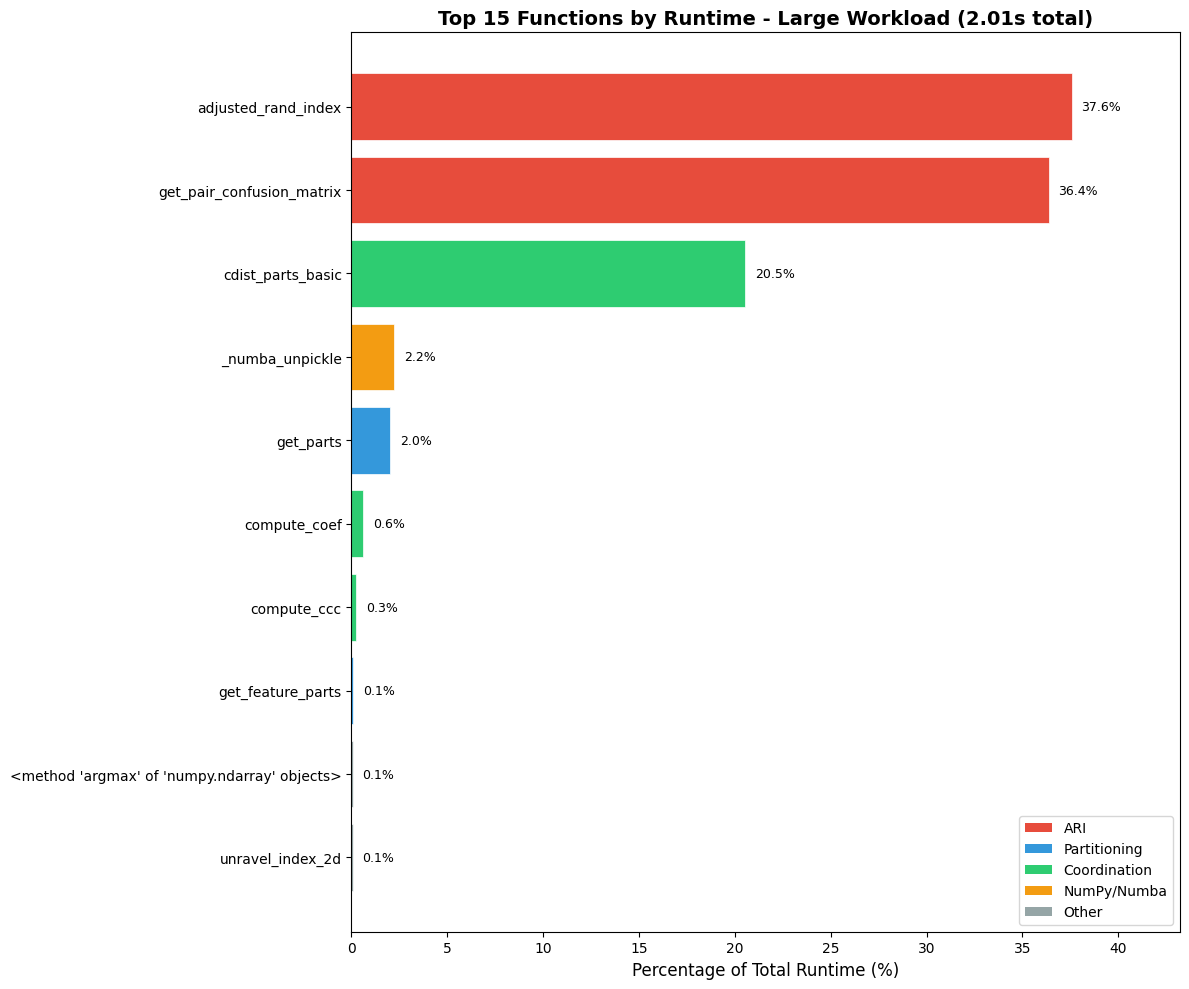

Figure saved as 'ccc_function_breakdown_bar.png'


In [12]:
# Horizontal bar chart showing top functions by runtime (for the Large workload)
# Using the largest workload for the most representative results
workload_name, func_df, total_time = all_func_dfs[-1]  # Large workload

fig, ax = plt.subplots(figsize=(12, 10))

# Prepare data - take top 15 functions
plot_df = func_df.head(15).copy()
plot_df = plot_df.iloc[::-1]  # Reverse for horizontal bar chart (highest at top)

# Create bars with category colors
colors = [CATEGORY_COLORS.get(cat, '#95a5a6') for cat in plot_df['Category']]
bars = ax.barh(range(len(plot_df)), plot_df['TotTime%'], color=colors, edgecolor='white', linewidth=0.5)

# Add function names on y-axis
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels([f"{row['Function']}" for _, row in plot_df.iterrows()], fontsize=10)

# Add percentage labels on bars
for i, (idx, row) in enumerate(plot_df.iterrows()):
    ax.text(row['TotTime%'] + 0.5, i, f"{row['TotTime%']:.1f}%", va='center', fontsize=9)

# Customize
ax.set_xlabel('Percentage of Total Runtime (%)', fontsize=12)
ax.set_title(f'Top 15 Functions by Runtime - {workload_name} Workload ({total_time:.2f}s total)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, max(plot_df['TotTime%']) * 1.15)

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat) 
                   for cat, color in CATEGORY_COLORS.items() 
                   if cat in plot_df['Category'].values]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('ccc_function_breakdown_bar.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'ccc_function_breakdown_bar.png'")

In [13]:
# Category totals summary across all workloads
print("Category Breakdown Summary")
print("=" * 80)

for workload_name, func_df, total_time in all_func_dfs:
    print(f"\n{workload_name} Workload (Total: {total_time:.4f}s):")
    print("-" * 50)
    
    cat_totals = calculate_category_totals(func_df, total_time)
    
    for _, row in cat_totals.iterrows():
        print(f"  {row['Category']:15s}: {row['TotTime']:.4f}s ({row['Percentage']:5.1f}%) - {int(row['Calls']):,} calls")

Category Breakdown Summary

Small Workload (Total: 0.0172s):
--------------------------------------------------
  ARI            : 0.0114s ( 66.4%) - 7,290 calls
  Coordination   : 0.0042s ( 24.1%) - 94 calls
  Partitioning   : 0.0007s (  4.0%) - 92 calls
  NumPy/Numba    : 0.0004s (  2.5%) - 3,741 calls
  Other CCC      : 0.0002s (  1.3%) - 66 calls
  Other          : 0.0001s (  0.4%) - 185 calls

Medium Workload (Total: 0.4684s):
--------------------------------------------------
  ARI            : 0.3394s ( 72.5%) - 198,450 calls
  Coordination   : 0.1068s ( 22.8%) - 2,452 calls
  NumPy/Numba    : 0.0112s (  2.4%) - 99,676 calls
  Partitioning   : 0.0091s (  1.9%) - 451 calls
  Other          : 0.0006s (  0.1%) - 2,454 calls
  Other CCC      : 0.0003s (  0.1%) - 1,225 calls

Large Workload (Total: 2.0101s):
--------------------------------------------------
  ARI            : 1.4864s ( 73.9%) - 801,900 calls
  Coordination   : 0.4303s ( 21.4%) - 9,901 calls
  NumPy/Numba    : 0.0448

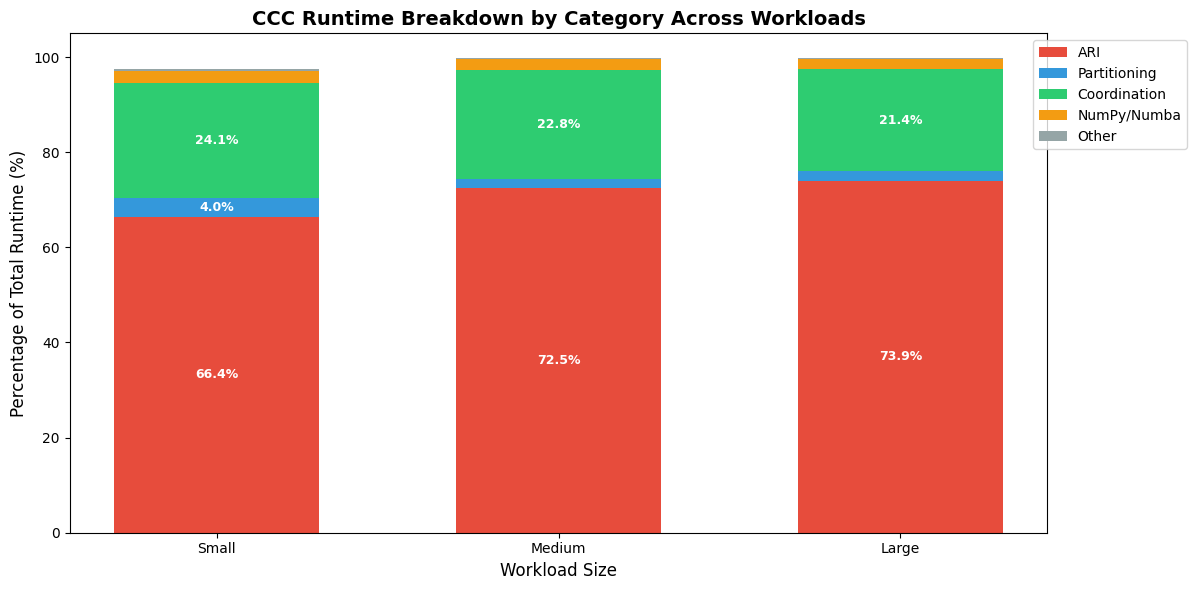

Figure saved as 'ccc_category_breakdown_comparison.png'


In [14]:
# Stacked bar chart comparing category breakdown across workloads
fig, ax = plt.subplots(figsize=(12, 6))

# Collect category data for each workload
workload_names = []
category_data = {cat: [] for cat in CATEGORY_COLORS.keys()}

for workload_name, func_df, total_time in all_func_dfs:
    workload_names.append(workload_name)
    cat_totals = calculate_category_totals(func_df, total_time)
    
    for cat in CATEGORY_COLORS.keys():
        cat_row = cat_totals[cat_totals['Category'] == cat]
        if len(cat_row) > 0:
            category_data[cat].append(cat_row['Percentage'].values[0])
        else:
            category_data[cat].append(0)

# Create stacked bar chart
x = np.arange(len(workload_names))
width = 0.6
bottom = np.zeros(len(workload_names))

# Only include categories that have data
active_categories = [(cat, data) for cat, data in category_data.items() if sum(data) > 0]

for cat, data in active_categories:
    ax.bar(x, data, width, label=cat, bottom=bottom, color=CATEGORY_COLORS[cat])
    
    # Add percentage labels
    for i, (d, b) in enumerate(zip(data, bottom)):
        if d > 3:  # Only label if > 3%
            ax.text(i, b + d/2, f'{d:.1f}%', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='white')
    
    bottom += np.array(data)

ax.set_ylabel('Percentage of Total Runtime (%)', fontsize=12)
ax.set_xlabel('Workload Size', fontsize=12)
ax.set_title('CCC Runtime Breakdown by Category Across Workloads', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(workload_names)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('ccc_category_breakdown_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'ccc_category_breakdown_comparison.png'")

## Visualizations

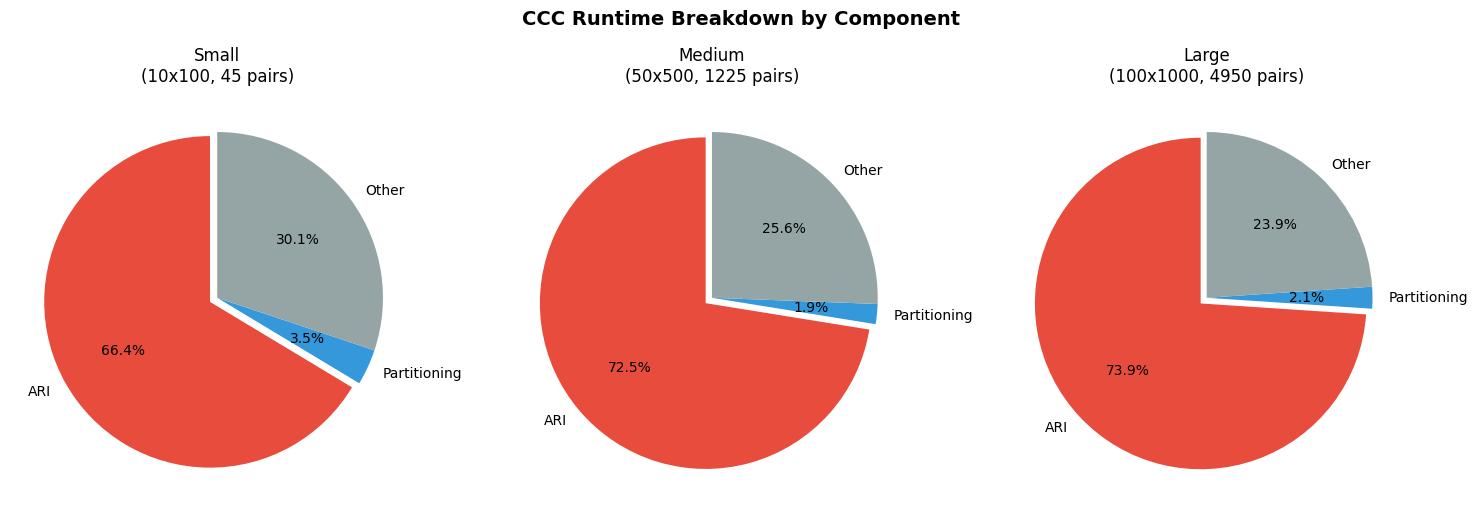

Figure saved as 'ccc_runtime_breakdown_pie.png'


In [15]:
# Set up the figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Colors for categories
colors = {'ARI': '#e74c3c', 'Partitioning': '#3498db', 'Other': '#95a5a6'}

for idx, r in enumerate(all_results):
    ax = axes[idx]
    
    # Data for pie chart
    sizes = [r['ari_pct'], r['partitioning_pct'], r['other_pct']]
    labels = ['ARI', 'Partitioning', 'Other']
    explode = (0.05, 0, 0)  # Explode ARI slice slightly
    
    wedges, texts, autotexts = ax.pie(
        sizes, 
        explode=explode,
        labels=labels,
        colors=[colors[l] for l in labels],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.6
    )
    
    ax.set_title(f"{r['workload']}\n({r['n_features']}x{r['n_samples']}, {r['n_pairs']} pairs)")

plt.suptitle('CCC Runtime Breakdown by Component', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ccc_runtime_breakdown_pie.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'ccc_runtime_breakdown_pie.png'")

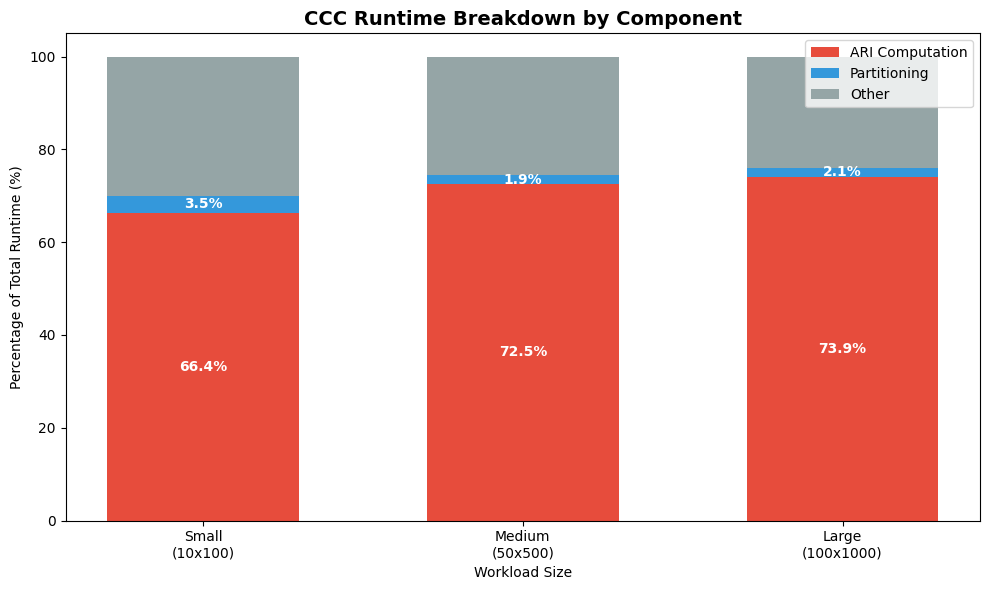

Figure saved as 'ccc_runtime_breakdown_bar.png'


In [16]:
# Stacked bar chart showing runtime breakdown
fig, ax = plt.subplots(figsize=(10, 6))

workload_names = [r['workload'] for r in all_results]
ari_pcts = [r['ari_pct'] for r in all_results]
part_pcts = [r['partitioning_pct'] for r in all_results]
other_pcts = [r['other_pct'] for r in all_results]

x = np.arange(len(workload_names))
width = 0.6

# Create stacked bars
bars1 = ax.bar(x, ari_pcts, width, label='ARI Computation', color='#e74c3c')
bars2 = ax.bar(x, part_pcts, width, bottom=ari_pcts, label='Partitioning', color='#3498db')
bars3 = ax.bar(x, other_pcts, width, bottom=[a+p for a,p in zip(ari_pcts, part_pcts)], 
               label='Other', color='#95a5a6')

# Add labels on bars
for i, (a, p, o) in enumerate(zip(ari_pcts, part_pcts, other_pcts)):
    ax.text(i, a/2, f'{a:.1f}%', ha='center', va='center', fontweight='bold', color='white')
    ax.text(i, a + p/2, f'{p:.1f}%', ha='center', va='center', fontweight='bold', color='white')

ax.set_ylabel('Percentage of Total Runtime (%)')
ax.set_xlabel('Workload Size')
ax.set_title('CCC Runtime Breakdown by Component', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{r['workload']}\n({r['n_features']}x{r['n_samples']})" for r in all_results])
ax.legend(loc='upper right')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('ccc_runtime_breakdown_bar.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'ccc_runtime_breakdown_bar.png'")

## Analysis and Conclusions

In [17]:
# Calculate average ARI percentage across all workloads
avg_ari_pct = np.mean([r['ari_pct'] for r in all_results])
min_ari_pct = min([r['ari_pct'] for r in all_results])
max_ari_pct = max([r['ari_pct'] for r in all_results])

print("="*80)
print("SUMMARY: ARI Computation as CCC Bottleneck")
print("="*80)
print(f"\nAcross the tested workloads:")
print(f"  - Average ARI percentage: {avg_ari_pct:.1f}%")
print(f"  - Range: {min_ari_pct:.1f}% to {max_ari_pct:.1f}%")
print(f"\nThese results demonstrate that ARI computation represents the")
print(f"dominant computational component of the CCC algorithm, consuming")
print(f"approximately {avg_ari_pct:.0f}% of the total runtime.")
print("\n" + "="*80)

SUMMARY: ARI Computation as CCC Bottleneck

Across the tested workloads:
  - Average ARI percentage: 70.9%
  - Range: 66.4% to 73.9%

These results demonstrate that ARI computation represents the
dominant computational component of the CCC algorithm, consuming
approximately 71% of the total runtime.



## Scaling Analysis: Number of ARI Calls

For a dataset with $n$ features and $k$ partitions per feature, CCC performs:
- $\frac{n(n-1)}{2}$ pairwise feature comparisons
- For each comparison: $k^2$ ARI calculations (comparing all partition pairs)

Total ARI calls: $\frac{n(n-1)}{2} \times k^2$

In [18]:
# Show number of ARI calls for each workload
print("Number of ARI Function Calls by Workload:")
print("-" * 50)

for r in all_results:
    ari_calls = r['func_times']['ari'].get('adjusted_rand_index', {}).get('ncalls', 'N/A')
    n_pairs = r['n_pairs']
    
    print(f"\n{r['workload']} ({r['n_features']}x{r['n_samples']}):")
    print(f"  - Pairwise comparisons: {n_pairs}")
    print(f"  - ARI function calls: {ari_calls}")
    if isinstance(ari_calls, int):
        print(f"  - Avg ARI calls per comparison: {ari_calls/n_pairs:.1f}")

Number of ARI Function Calls by Workload:
--------------------------------------------------

Small (10x100):
  - Pairwise comparisons: 45
  - ARI function calls: 3645
  - Avg ARI calls per comparison: 81.0

Medium (50x500):
  - Pairwise comparisons: 1225
  - ARI function calls: 99225
  - Avg ARI calls per comparison: 81.0

Large (100x1000):
  - Pairwise comparisons: 4950
  - ARI function calls: 400950
  - Avg ARI calls per comparison: 81.0


---

## Appendix: Full Profiling Output

For reference, here is the complete cProfile output for the large workload.

In [19]:
# Re-run profiling for large workload and show full stats
print("Full cProfile output for Large workload (100x1000):")
print("=" * 80)

data = generate_synthetic_data(100, 1000)
stats, _ = profile_ccc(data, n_jobs=1)

# Print top 20 functions by cumulative time
stats.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

Full cProfile output for Large workload (100x1000):
         1240579 function calls in 2.026 seconds

   Ordered by: cumulative time
   List reduced from 107 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    2.026    2.026 impl.py:587(ccc)
        1    0.012    0.012    1.981    1.981 impl.py:451(compute_coef)
     4950    0.005    0.000    1.968    0.000 impl.py:386(compute_ccc)
     4950    0.411    0.000    1.959    0.000 impl.py:247(cdist_parts_basic)
   400950    0.760    0.000    1.547    0.000 metrics.py:117(adjusted_rand_index)
   400950    0.742    0.000    0.787    0.000 metrics.py:76(get_pair_confusion_matrix)
   401851    0.045    0.000    0.045    0.000 serialize.py:30(_numba_unpickle)
        1    0.001    0.001    0.043    0.043 impl.py:156(get_feature_parts)
      900    0.041    0.000    0.042    0.000 impl.py:114(get_parts)
     4950    0.001    0.000    0.001    0.000 {method 'argmax'